In [1]:
# %%

import sys
import argparse

import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from pymol import cmd
import os

colorbar_max = 0.2
delta_LD_threshold = 0.075

# preprocessing: get cleaned peptide dataframe

# using txt list of good peptides, get new csv with only desired peptides

# USAGE: 'pymol -r [this script].py [all flags + args]
#
# COMMAND LINE ARGS:
# --pm PYMOL FETCH CODE .pdb
# --t  PEPTIDE POOL RESULTS TABLEmv .csv
# --r  RANGES LIST PATH .csv (optional but recommended)
# --s1 STATE 1 for pymol comparison (optional, CASE SENSITIVE)
# --s2 STATE 2 for pymol comparison (optional, CASE SENSITIVE)
# --compare     3 STATES for 'both' comparison, [dna, ligand, both] (optional, CASE SENSITIVE)
# --cbarmax     MAX VALUE for colorbar (optional, for pymol)
# --ldmax       MIN VALUE for delta-LD for ternary value to be calculated (optional, for 'compare' option)

parser = argparse.ArgumentParser(description='Statistical analysis of HDX/MS data for curated RbsR peptides in one or more functional states.')
parser.add_argument('--pm', dest='pm', help="path to pymol structure", required=True)
parser.add_argument('--t', '--table', dest='table', help="path to uptake table", nargs='+', required=True)
parser.add_argument('--r', '--ranges', dest='ranges', help='path to ranges list csv')
parser.add_argument('--e', '--exclude', dest='exclude', action='store_true', help='exclude rather than include rangeslist')
parser.add_argument('--s1', dest='s1', help='first state to compare')
parser.add_argument('--s2', dest='s2', help='second state to compare')
parser.add_argument('--compare', dest='compare', help='dna, ligand, both', nargs=3)
parser.add_argument('--cbarmax', dest='cbarmax', type=float, help='max value for colorbar axis for dDbar')
parser.add_argument('--ldmin', dest='ldmin', type=float, help='in dDbar, minimum difference threshold between ligand/dna states')



args = parser.parse_args(args=['--t', './example/10-25_rbsb_pool_results-CLEANED.csv',
                               '--r', './example/rangeslist-10-25.csv', 
                               '--pm', './example/2dri_protein.pdb',
                               '--ldmin','0.3'])
print(args)

cmd.load(args.pm)


if args.cbarmax is not None:
    colorbar_max = args.cbarmax
if args.ldmin is not None:
    delta_LD_threshold = args.ldmin

newbigdf = pd.DataFrame()
for table in args.table:
    bigdf = pd.read_csv(table)


    tpdict = {}
    header = bigdf.iloc[:,0:8]
    header.columns = header.iloc[0]
    header.drop(0,inplace=True)
    tp_frames = bigdf.columns[8::8]
    for i in range(len(tp_frames)):
       tp_frame = tp_frames[i]
       tpdict[tp_frame] = bigdf.iloc[:,8+8*i:16+8*i]
       tpdict[tp_frame].columns = tpdict[tp_frame].iloc[0]
       tpdict[tp_frame].drop(0,inplace=True)
       tpdict[tp_frame] = pd.concat([header,tpdict[tp_frame]], axis=1)
       tpdict[tp_frame]['Deut Time (sec)'] = float(tp_frame.split('s')[0])
       newbigdf = pd.concat([newbigdf, tpdict[tp_frame]])
newbigdf['Start'] = newbigdf['Start'].apply(np.int64)
newbigdf['End'] = newbigdf['End'].apply(np.int64)
newbigdf['#D'] = newbigdf['#D'].apply(float)

if args.exclude:
    rangeslist = pd.read_csv(args.ranges)
    exc = pd.merge(newbigdf, rangeslist, how='left', indicator=True)
    cleaned = exc[exc['_merge']=='left_only'].drop('_merge', axis=1)
elif args.ranges is not None:
    rangeslist = pd.read_csv(args.ranges)
    cleaned = pd.merge(rangeslist, newbigdf)
else:
    cleaned = newbigdf.drop_duplicates()
#cleaned.dropna(subset=['#D'],inplace=True)

states = list(dict.fromkeys(cleaned['State']))
#states.sort()
peptides = list(dict.fromkeys(cleaned['Sequence']))
#peptides.sort()
timepoints = list(dict.fromkeys(cleaned['Deut Time (sec)']))
#timepoints.sort()

cleaned = cleaned.groupby(['Sequence', 'Deut Time (sec)', 'State', 'Start', 'End'])['#D'].agg(['mean','std', 'count'])
cleaned.reset_index(inplace=True)
cleaned.rename(columns={'mean':'#D', 'std': 'Stddev', 'count':'#Rep', 'State':'Protein State'}, inplace=True)
if 0 not in timepoints:
    tp0s = cleaned.groupby(['Sequence', 'Protein State', 'Start', 'End']).sum()
    tp0s['Deut Time (sec)'] = 0
    tp0s['#D'] = 0.0
    tp0s['Stddev'] = 0.0
    tp0s['#Rep'] = 1
    cleaned = pd.concat([cleaned, tp0s.reset_index()]).sort_values(by=['Start', 'End', 'Deut Time (sec)', 'Protein State'])
    timepoints = [0] + timepoints

# preprocessing: imitate dictionary format from below
sequence_df = cleaned.loc[(cleaned['Protein State'] == states[0]) & (cleaned['Deut Time (sec)'] == 0)][['Start', 'End', 'Sequence']].drop_duplicates().reset_index()
states_dict = {}
for state in states:
    states_dict[state] = sequence_df.copy()
first_res = sequence_df['Start']


peptides_2 = [str(sequence_df['Start'][i])+'-'+str(sequence_df['End'][i])+'- '+sequence_df['Sequence'][i] for i in range(len(sequence_df['Sequence']))]
#peptides_2: list of peptides with format [start]-[end]- [sequence]



Namespace(pm='./example/2dri_protein.pdb', table=['./example/10-25_rbsb_pool_results-CLEANED.csv'], ranges='./example/rangeslist-10-25.csv', exclude=False, s1=None, s2=None, compare=None, cbarmax=None, ldmin=0.3)


/tmp/ipykernel_1696652/2555230179.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  header.drop(0,inplace=True)
/tmp/ipykernel_1696652/2555230179.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tpdict[tp_frame].drop(0,inplace=True)
/tmp/ipykernel_1696652/2555230179.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tpdict[tp_frame].drop(0,inplace=True)
/tmp/ipykernel_1696652/2555230179.py:79: SettingWithCopyWarning: 
A value 

In [18]:

# ### Compile exchange information for each peptide for chosen states.

# create dictionary keys from peptides
# in subsequent code: add state and each TP avg exchange measurements as values for peptide keys
peptide_exchange_dict = {}
for state in states:
    for peptide in states_dict[state]['Sequence']:
        if peptide not in peptide_exchange_dict:
            peptide_exchange_dict[peptide] = {}
        peptide_exchange = (cleaned.loc[(cleaned['Sequence'] == peptide) & (cleaned['Protein State'] == state)][['#D']]).values[:]#[:9]
        peptide_exchange_dict[peptide][state] = peptide_exchange

stdev_dict_dict = {}
for state in states:
    stdev_dict_dict[state] = {}
    for peptide in peptides:
        stdev_dict_dict[state][peptide] = (cleaned.loc[(cleaned['Sequence'] == peptide) & (cleaned['Protein State'] == state)][['Stddev']]).values


# ### Plot H/D exchange functions as uptake plots for each peptide for each state.

# fitting

array([[0.   ],
       [1.646],
       [  nan],
       [1.527],
       [1.561],
       [1.542],
       [1.584],
       [1.703],
       [1.838]])

In [26]:
timepoints

[0, 30.0, 120.0, 480.0, 960.0, 1920.0, 3840.0, 7680.0, 15360.0]

In [8]:


def exchange_fit(x, a, b, c, d, e, f, g):
    return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g

def exchange_fit_low(x, b, c, e, f, g):
    return max_protons - b * np.exp(-e * x) - c * np.exp(-f * x) - g

trialT = np.logspace(1.5, np.log10(max(timepoints)*2), 1000)


# create dictionary keys from peptides
# in subsequent code: add state and FITS (long vectors) as values for peptide keys (peptide_fit_dict)
# add state and popt curvefit PARAMS for peptide keys (peptide_params_dict)

peptide_fit_dict = {}
peptide_params_dict = {}
peptide_err_dict = {}


for peptide in peptides:
    peptide_fit_dict[peptide] = []
    peptide_params_dict[peptide] = []
    peptide_err_dict[peptide] = []
    num_prolines = peptide[2:].count('P')
    max_protons = len(peptide) - 2 - num_prolines

    element = peptide_exchange_dict.get(peptide) # element is state
    if element is not None:
        for state in element.keys():
            exchange_list = element[state] # these are the avg tp measurements for the state

            # create sub-dictionaries that links state (key) to fits or params (values),
            # then add sub-dicts as values to peptide_fit_dict or peptide_params_dict

            sub_fit_dict = {}
            sub_params_dict = {}
            sub_err_dict = {}

            p1_index = 0
            peptide1_tps = []
            peptide1_ex = []
            for tp in exchange_list:
                if not math.isnan(float(tp)):
                    peptide1_tps.append(timepoints[p1_index])
                    peptide1_ex.append(float(tp))
                p1_index = p1_index + 1
            try:
                if peptide1_ex[-1] > .5:

                    popt, pcov = curve_fit(f = exchange_fit, xdata = peptide1_tps, ydata = peptide1_ex,
                                        bounds = (0, [max_protons, max_protons, max_protons, 1, .1, .01, max_protons]),
                                        maxfev = 10000)
                    exchange_peptide1 = exchange_fit(trialT, *popt)
                    perr = np.sqrt(np.diag(pcov))

                else:

                    popt, pcov = curve_fit(f = exchange_fit_low, xdata = peptide1_tps, ydata = peptide1_ex,
                                        bounds = (0, [max_protons, max_protons, .1, .01, max_protons]),
                                        maxfev = 10000)
                    exchange_peptide1 = exchange_fit_low(trialT, *popt)
                    perr = np.sqrt(np.diag(pcov))
            except:
                #print(peptide)
                popt, pcov = np.zeros(popt.shape), np.zeros(pcov.shape)
            sub_fit_dict[state] = exchange_peptide1
            sub_params_dict[state] = popt
            sub_err_dict[state] = perr
            peptide_fit_dict[peptide].append(sub_fit_dict)
            peptide_params_dict[peptide].append(sub_params_dict)
            peptide_err_dict[peptide].append(sub_err_dict)


/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [27]:
stdev_dict_dict['Apo'][peptides[0]]

array([[ 0.],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [30]:
peptide_exchange_dict[peptides[0]]

{'Apo': array([[0.   ],
        [1.646],
        [  nan],
        [1.527],
        [1.561],
        [1.542],
        [1.584],
        [1.703],
        [1.838]]),
 'Ribose': array([[0.   ],
        [1.265],
        [1.237],
        [1.441],
        [1.544],
        [1.483],
        [  nan],
        [1.666],
        [1.731]])}

In [14]:


# plotting

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 36
       }
axes = {'titlesize' : 36,
        'titleweight' : 'bold',
        'labelsize' : 36
       }

plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('lines', lw = 3)
color_dict = {}
colors = ['k', 'red', 'blue', 'purple', 'gray', 'orange', 'yellow', 'green', 'brown']
for i in range(len(states)):
    color_dict[states[i]] = colors[i]



figure, (ax1) = plt.subplots(1, 1, figsize=(9,8))


def shift_seq_index(peptides_2_item, shift):
    start = int(peptides_2_item.split('- ')[0].split('-')[0]) + shift
    end = int(peptides_2_item.split('- ')[0].split('-')[1]) + shift
    return str(start) + '-' + str(end) + '- ' + peptides_2_item.split('- ')[1]


for peptide in peptide_exchange_dict:
    element = peptide_exchange_dict.get(peptide)

    if element is not None:

        for state in element:

            for key in stdev_dict_dict:
                if state == key:
                    current_stdev_dict = stdev_dict_dict.get(key)
                    current_stdev = current_stdev_dict.get(peptide).flatten()[0:len(timepoints)]
            
            if element.get(state).size != 0:
                ax1.plot(timepoints, element.get(state), 'o', label = state, markersize = 18, alpha = 0.5,
                    color = color_dict.get(state))
            #ax1.errorbar(timepoints, element.get(state), yerr=current_stdev, linestyle="None",
            #             ecolor = color_dict.get(state), capsize = 3, linewidth = 2)

            for element_2 in peptide_fit_dict.get(peptide):
                for e2_key in element_2:
                    if e2_key == state:
                        ax1.plot(trialT, element_2.get(state), '-', color = color_dict.get(state))
            for list_item in peptides_2:
                title_string = "- " + peptide
                y_lim = len(peptide) - 2 - peptide[2:].count('P') + 0.25
                if list_item.endswith(title_string):
                    #plot_title = list_item
                    plot_title = shift_seq_index(list_item, -14)

        ax1.set_ylabel('# Deuterons')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_title(plot_title)
        ax1.set_xscale('log')
        ax1.set_ylim(0, y_lim)
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        plt.legend(frameon = False, bbox_to_anchor=(1.03, 1.03))
        # change this line to save in the right place...
        if not os.path.exists('plots/'):
            os.mkdir('plots/')
        plt.savefig('plots/' + plot_title + '.png', bbox_inches='tight')
        ax1.clear()
plt.close()



['Apo', 'Ribose']


/tmp/ipykernel_1696652/2749074081.py:252: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(cmap=colmap, norm=norm))
/tmp/ipykernel_1696652/2749074081.py:275: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(cmap=colmap, norm=norm))


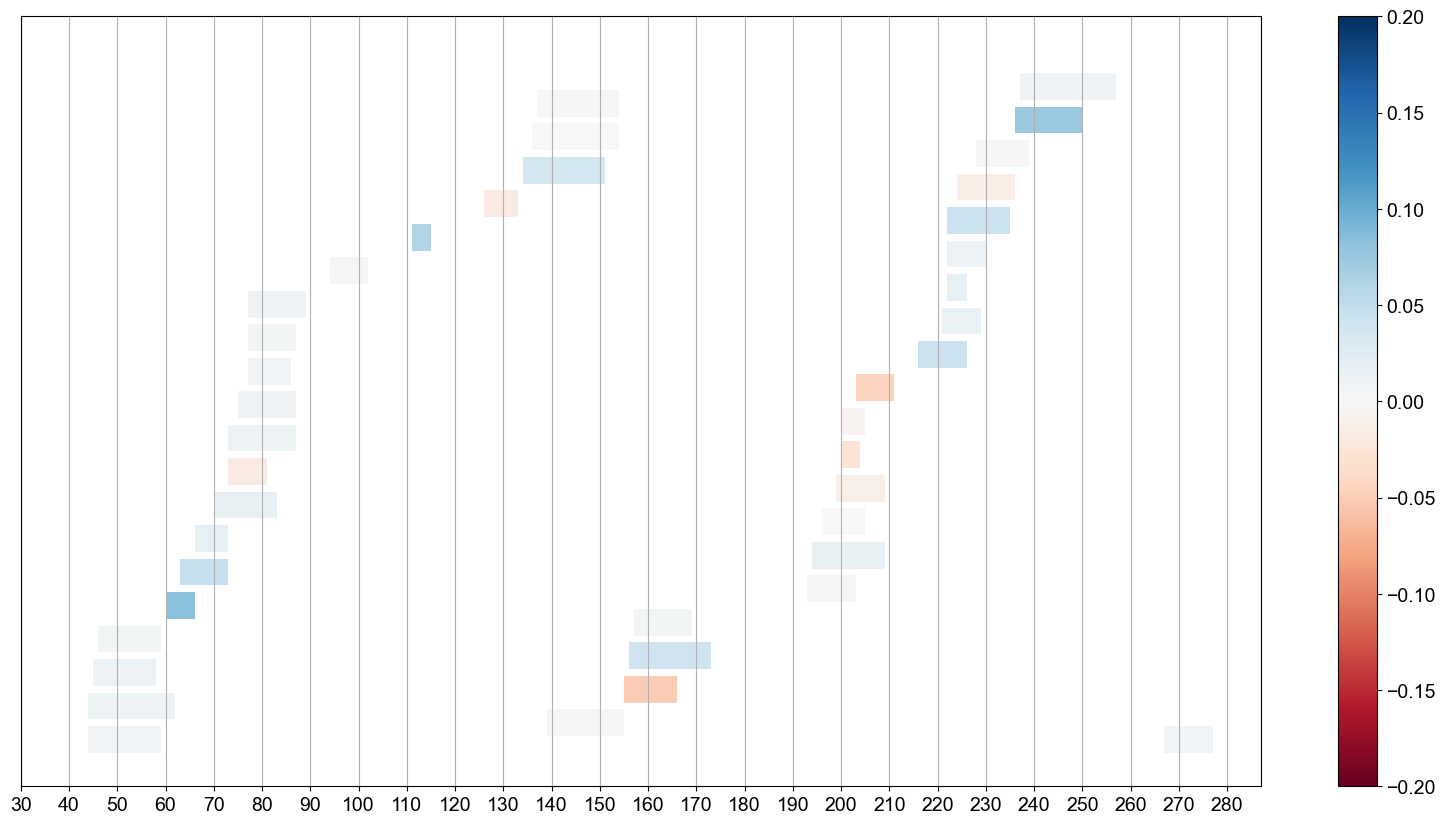

In [15]:

peptides_2 = [str(sequence_df['Start'][i])+'-'+str(sequence_df['End'][i])+'- '+sequence_df['Sequence'][i] for i in range(len(sequence_df['Sequence']))][3:]
#peptides_2: list of peptides with format [start]-[end]- [sequence]


# ### Compute differential HDX expressions.

# make set of all pair options
if len(states) > 1:
    pairs = []
    for state1 in states:
        for state2 in states:
            if [state2, state1] not in pairs and state1 != state2:
                pairs.append([state1, state2])

    # for the sake of keeping data structures around: this is all now a giant loop. Can restore old
    # state picking behavior or save/load csvs instead if desired.

    if (args.s1 is not None) and (args.s2 is not None):
        pairs.append([args.s1, args.s2])

    dDt_tps_dict_dict = {}
    dDS_dict_dict = {}
    dDbar_dict_dict = {}
    dDbar_dfs = {}
    for pair in pairs:
        print(pair)

        # create dictionary for deuteration differences at all HDX tps

        dDt_tps_dict = {}
        dDS_dict = {}
        dDbar_dict = {}

        for peptide in peptide_exchange_dict:
            dDt_tps = []
            for key in peptide_exchange_dict.get(peptide):
                if key in pair:
                    dDt_tps.append(np.array(peptide_exchange_dict.get(peptide).get(key)))

            # calculate dDS - sum dDt
            if dDt_tps[0].size == dDt_tps[1].size:
                dDS = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
                n_T = len(dDS) # number of distinct HX labeling times for the peptide, discounting NaNs
                #n_T = n_T - sum([math.isnan(diff) for diff in dDS]) # number of distinct times, actually discounting NaNs
                dDS_dict[peptide] = [np.nansum(dDS)] # deuteration difference summed over all HX times, no NaNs
        #        if(np.nan in sum(dDS)):
        #            print(dDS)
                dDbar_dict[peptide] = [np.nansum(dDS)/n_T] # arithmetic mean deuteration difference across all HX times, no NaNs
        #        print(np.nansum(dDS))
        #        print(dDbar_dict[peptide])
                # calculate dHXt - dDt/(N_H * m_d)
                dDt_tps = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
                dDt_tps_dict[peptide] = dDt_tps

        # generating lists for heatmap
        heatmap_timepoints = timepoints * len(peptides_2)

        heatmap_peptides = []
        heatmap_values = []
        for peptide in peptides_2:
            temp_peptides = [peptide]*len(timepoints)
            heatmap_peptides.append(temp_peptides)
            flat_list = []
            if peptide.split()[1] in dDt_tps_dict.keys():
                heatmap_values = heatmap_values + (list(dDt_tps_dict[peptide.split()[1]][:,0]))
                for sublist in heatmap_peptides:
                    for item in sublist:
                        flat_list.append(item)

        heatmap_df = pd.DataFrame({'Timepoints (seconds)': heatmap_timepoints, 'Peptides': flat_list,
                                'Sensitivity': heatmap_values })
        # plot it

        font = {'family' : 'Arial',
                'weight' : 'normal',
                'size'   : 14
            }
        axes = {'titlesize' : 18,
                'titleweight' : 'bold',
                'labelsize' : 16
            }

        plt.rc('font', **font)
        plt.rc('axes', **axes)

        plt.rcParams['figure.figsize'] = (4, 25)
        plt.rcParams['font.size'] = 14
        plt.rcParams['font.family'] = 'Arial'

        df_wide=heatmap_df.pivot_table( index='Peptides', columns='Timepoints (seconds)', values='Sensitivity' )
        df_wide.index = pd.CategoricalIndex(df_wide.index, categories = peptides_2)
        df_wide.sort_index(level=0, inplace=True)

        cmap = sns.color_palette("vlag", as_cmap=True)
        fig = plt.figure()
        p2 = sns.heatmap( df_wide, cmap='RdBu', linewidths=.75, vmin=-.75, vmax=.75)
        p2.set_title("\u0394HX$_{t}$, " + pair[0] + ' - ' + pair[1])
        #plt.savefig('plots/dHXt_' + pair[0] + '_' + pair[1] + '.png', bbox_inches="tight")
        plt.close()


        # determine uncertainties in dHXt

        reps_df = cleaned[['#Rep', 'Sequence', 'Protein State']]
        newreps_df = pd.DataFrame()
        for Sequence in set(reps_df['Sequence']):
            newrow = [Sequence]
            for state in states:
                newrow.append(reps_df.loc[(reps_df['Sequence']==Sequence) & (reps_df['Protein State']==state)]['#Rep'].sum())
            newreps_df = pd.concat([newreps_df, pd.DataFrame([newrow], columns=['Sequence']+states)])
        reps_df = newreps_df
        reps_dict_list = reps_df.to_dict('records')


        # change the state labels to change which uncertainties are calculated

        for dict_key in stdev_dict_dict.keys():
            if pair[0] in dict_key:
                dict1 = stdev_dict_dict.get(dict_key)
            if pair[1] in dict_key:
                dict2 = stdev_dict_dict.get(dict_key)


        for (k,v), (k2,v2) in zip(dict1.items(), dict2.items()):
            squared_mA = [number ** 2 for number in v]
            squared_mB = [number ** 2 for number in v2]

            for element in reps_dict_list:
                if element.get("Sequence") == k:
                    n_mA = element.get(pair[0])
                    n_mB = element.get(pair[1])

            u_dDt = []
            for a, b in zip(squared_mA, squared_mB):
                u_dDt.append( math.sqrt( (a/n_mA) + (b/n_mB) ) )

            max_protons = len(k) - 2 - peptide[2:].count('P')

            u_dHXt = []
            for element in u_dDt:
                u_dHXt.append( (element**2)/max_protons )

        #    print(k)
        #    print(u_dDt)
        #    print(u_dHXt)



        dDbar_heatmap_df = pd.DataFrame({'dDbar': 'dDbar', 'Sequence': peptides_2,
                'Sensitivity': [dDbar_dict[peptide.split()[1]][0] for peptide in peptides_2],
                'seq': [peptide.split(' ')[1] for peptide in peptides_2],
                'Start': [int(float(peptide.split('-')[0])) for peptide in peptides_2],
                'End': [int(float(peptide.split('-')[1])) for peptide in peptides_2]})
        dDbar_heatmap_df.to_csv('plots/peptide_df_' + pair[0] + '_' + pair[1])
        # plot it
        font = {'family' : 'Arial',
                'weight' : 'normal',
                'size'   : 14
            }
        axes = {'titlesize' : 14,
                'titleweight' : 'bold',
                'labelsize' : 24
            }

        plt.rc('font', **font)
        plt.rc('axes', **axes)

        plt.rcParams['figure.figsize'] = (2, 25)
        plt.rcParams['font.size'] = 14
        plt.rcParams['font.family'] = 'Arial'
        fig = plt.figure()
        dDbar_df_wide = dDbar_heatmap_df.pivot_table( index='Sequence', columns='dDbar', values='Sensitivity' )
        dDbar_df_wide.index = pd.CategoricalIndex(dDbar_df_wide.index, categories = peptides_2)
        dDbar_df_wide.sort_index(level=0, inplace=True)

        p2 = sns.heatmap( dDbar_df_wide, cmap="RdBu", linewidths = 1, vmin = -colorbar_max, vmax = colorbar_max)
        p2.set_title(pair[0] + '-\n' + pair[1])
        #plt.savefig('plots/dDbar_' + '-'.join(pair) + '.png', bbox_inches="tight")
        plt.close()

        fullseq = cmd.get_fastastr('all').split('>')[1]
        fullseq = ''.join(fullseq.split('\n')[1:])
        residue_array = np.zeros(len(fullseq))
        residue_array[:] = np.nan
        sorted_heatmap_df = dDbar_heatmap_df.sort_values(by='seq', key=lambda ser: [len(s) for s in ser], ascending=False)
        for i in range(len(sorted_heatmap_df['seq'])):
            residue_array[sorted_heatmap_df['Start'][i]:sorted_heatmap_df['End'][i]] = sorted_heatmap_df['Sensitivity'][i]
        np.savetxt('plots/dD_res_level_' + pair[0] + '_' + pair[1] + '.csv', residue_array, delimiter=',')

        # save rgb values for pymol

        df = dDbar_heatmap_df
        df.to_csv('plots/'+'-'.join(pair)+"-heatmapdf.csv")
        #print(df)
        s = df['Sensitivity'].copy()
        # top = max([max(s), -min(s)])
        # s = s + top
        # s = s / (2 * top)
        top = colorbar_max
        s = s + top
        s = s / (2 * top)
        s.clip(upper=1, lower=0, inplace=True)
        colmap = plt.get_cmap("RdBu")
        rgb = colmap(s)*255
        newdf = pd.DataFrame()
        newdf['Sequence'] = df['Sequence']
        newdf['r'] = rgb[:,0]
        newdf['g'] = rgb[:,1]
        newdf['b'] = rgb[:,2]

        ### pymol section: remove it and the above comment and run pymol_test.py if desired

        rgb = newdf

        #print(rgb.shape)
        rgb.sort_values(by='Sequence', key=lambda ser: [len(s.split()[1]) for s in ser], ascending=False, inplace=True)
        rgb.reset_index(inplace=True)
        #print(rgb.shape)
        #print(rgb)
        #print(rgb['Sequence'])
        cmd.color("gray")

        for i in range(len(rgb['Sequence'])):
            seq = rgb['Sequence'][i].split()[-1]
            #rnge = rgb['Sequence'][i].split()[0][:-1]
            #rnge = rnge.split('-')
            # rnge = '-'.join([str(int(float(rnge[0]))+2-25),str(int(float(rnge[1]))-25)])
            #rnge = '-'.join([str(int(float(rnge[0])) + 2), str(int(float(rnge[1])))])
            #if (rnge[0] != '-'):
            #    cmd.select(seq, 'resi ' + rnge)
            #    cmd.set_color(seq, [rgb['r'][i], rgb['g'][i], rgb['b'][i]])
            #    cmd.color(seq, seq)
            cmd.select(seq, 'pepseq ' + seq)
            cmd.set_color(seq, [rgb['r'][i], rgb['g'][i], rgb['b'][i]])
            cmd.color(seq, seq)
        cmd.ray(1000,1000)
        cmd.save('plots/'+'-'.join(pair)+"-pm.pse")

        df.sort_values(by=['Start','End'], inplace=True)

        fig, ax = plt.subplots(figsize=(20,10))
        leftbound = df['Start'][0]-10
        rightbound = max(df['End'])+10
        ax.set_xlim(leftbound,rightbound)
        ax.xaxis.set_ticks(np.arange(round(leftbound,-1), round(rightbound,-1), 10))
        ax.set_ylim(-5,110)
        ax.grid(axis='x')
        ax.yaxis.set_ticks([])
        norm = col.Normalize(vmin=-colorbar_max,vmax=colorbar_max)
        for i in range(len(df['Start'])):
            ax.add_patch(Rectangle((df['Start'][i], (i%20)*5 + ((i//20)%2)*2.5), df['End'][i]-df['Start'][i],4, fc=colmap(norm(df['Sensitivity'][i]))))
        fig.colorbar(cm.ScalarMappable(cmap=colmap, norm=norm))
        #plt.show()
        #plt.savefig('plots/coverage-'+'-'.join(pair)+'.png', )
        plt.close()
        pairtuple = tuple(pair)
        dDt_tps_dict_dict[pairtuple] = dDt_tps_dict.copy()
        dDS_dict_dict[pairtuple] = dDS_dict.copy()
        dDbar_dict_dict[pairtuple] = dDbar_dict.copy()
        dDbar_dfs[pairtuple] = df.copy()



    fig, ax = plt.subplots(figsize=(20,10))
    leftbound = df['Start'][0]-10
    rightbound = max(df['End'])+10
    ax.set_xlim(leftbound,rightbound)
    ax.xaxis.set_ticks(np.arange(round(leftbound,-1), round(rightbound,-1), 10))
    ax.set_ylim(-5,110)
    ax.grid(axis='x')
    ax.yaxis.set_ticks([])
    norm = col.Normalize(vmin=-colorbar_max,vmax=colorbar_max)
    for i in range(len(df['Start'])):
        ax.add_patch(Rectangle((df['Start'][i], (i%20)*5 + ((i//20)%2)*2.5), df['End'][i]-df['Start'][i],4, fc=colmap(norm(df['Sensitivity'][i]))))
    fig.colorbar(cm.ScalarMappable(cmap=colmap, norm=norm))

